# **Task 2: Visualizing Attention and Analyzing the “Attention Sink” Phenomenon**

## **Overview**
Explores **Transformer self-attention** by capturing, visualizing, and quantifying attention maps, then simulates how **StreamLLM** leverages the *“attention sink”* to enable long-sequence generation with fixed memory.  
The notebook adds `output_attentions=True` for introspection, builds a hook-based **Attention Catcher**, measures sink attention across layers, and contrasts standard **KV caching** with a **StreamLLM-style cache** that trims middle tokens while preserving sinks and recency.

---

## **Step 1: Load the Model in Investigation Mode (Cell 4)**

- **Enable attention outputs:**  
  Load the model with  
  `AutoModelForCausalLM.from_pretrained(..., output_attentions=True)`  
  so each forward pass returns per-layer attention tensors alongside logits.

- **Tokenization setup:**  
  Initialize the matching `AutoTokenizer` and standard generation configs used throughout experiments.

---

## **Step 2: Build the “Attention Catcher” Toolkit (Cell 5)**

- **Global storage:**  
  `attention_maps_storage` keeps captured attention tensors keyed by layer/module identifiers.

- **Hook factory:**  
  `get_attention_hook` returns a forward hook that extracts `attn_weights` during the pass and stores them in `attention_maps_storage`.

- **Hook registrar:**  
  `register_attention_hooks(model, layers=...)` attaches the hook to each chosen self-attention module (single layer, a subset, or all layers).

- **Visualization:**  
  `plot_attention_maps` retrieves saved maps, aggregates across heads (e.g., mean over heads), and renders **attention heatmaps** for inspection.

---

## **Step 3: Experiment 1 — Attention Patterns Across Inputs (Cell 6)**

- **Inputs:**  
  Define `INPUT_TEXTS` with both meaningful sentences and repetitive “dummy” strings of varying lengths.

- **Hook installation:**  
  Call `register_attention_hooks` for selected layers; clear `attention_maps_storage` before each run.

- **Single forward pass:**  
  Tokenize each input and run a forward pass to populate attention storage via hooks.

- **Heatmaps:**  
  Use `plot_attention_maps` to visualize per-layer attention, aggregated across heads, for side-by-side comparison across inputs.

- **Cleanup:**  
  Remove all hooks after the experiment to avoid extra overhead later.

---

## **Step 4: Experiment 2 — Quantifying the Attention Sink (Cell 7)**

- **Full-depth monitoring:**  
  Register hooks on every layer to capture a complete attention profile across the model.

- **Sink metric:**  
  For each input and layer, compute the fraction of attention mass directed to the first `SINK_TOKEN_WINDOW` tokens, averaging across heads and query positions.

- **Trends by layer:**  
  Store results and plot layer-wise curves  
  *(x-axis: layer ID; y-axis: sink attention %)*  
  with separate lines per input type to reveal consistent sink patterns.

---

## **Step 5 (Advanced): StreamLLM Simulation and Memory Advantage (Cells 8–9)**

- **Positional shift attention:**  
  `llama_pos_shift_attention_forward` modifies the attention forward path to dynamically adjust positional encodings (e.g., RoPE phases) when intermediate tokens are evicted, preserving correct relative positions among the remaining tokens.

- **KV cache manager:**  
  `streamingllm_kv` tracks and trims the KV cache by discarding middle tokens once capacity is exceeded, keeping only early “sink” tokens and the most recent tokens.

- **Baseline vs. StreamLLM:**  
  - `run_baseline_experiment`: Standard generation where KV cache grows linearly with sequence length; log memory usage over steps.  
  - `run_streamllm_experiment`: Generation with `streamingllm_kv` trimming after each step; log memory usage for comparison.

- **Analysis:**  
  Plot both memory curves against generated tokens to show linear growth (**baseline**) vs. plateau (**StreamLLM-style trimming**), illustrating fixed-memory long-context generation.

---

## **Results and Takeaways**

- **Memory efficiency:**  
  StreamLLM-style KV trimming flattens memory growth, enabling sustained generation without exhausting memory.

- **Output quality:**  
  Standard full-cache generation degrades (e.g., incoherent characters) far beyond training lengths, while StreamLLM maintains more coherent outputs under extended contexts.


In [89]:
### Cell 2: Environment Setup and Dependency Installation
# TODO: import all required libraries for the lab (os, random, time, numpy, pandas, torch, transformers, etc.)

import os
import random
import time
import numpy as np
import pandas as pd
import torch
import transformers

RESULTS_DIR = "./results"
FIGURES_DIR = "./figures"

# TODO: create the results/figures directories if they do not exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# TODO: configure logging verbosity and select DEVICE (cuda vs. cpu)
device = "cuda"
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available!")
else:
    # Check for some stupid error on PACE where CUDA actually is not supported
    a = torch.randn(1024, 1024, device=device)
    b = torch.randn(1024, 1024, device=device)
    c = torch.matmul(a, b)
    print(f"Did CUDA work? {c.sum()}")

# TODO: print environment diagnostics (CUDA version, PyTorch version, etc.)

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch RNGs for reproducible lab runs."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
print("Environment initialised.")


Did CUDA work? 29661.49609375
Environment initialised.


In [ ]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# # Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        # custom token made for this project, no security risk here
        hf_token = "removed"
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.
   Hugging Face login successful!


In [91]:
### Cell 4: Load Model and Tokenizer
MODEL_ID = "meta-llama/Llama-3-8B-Instruct"
FALLBACK_MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"

from transformers import AutoModelForCausalLM, AutoTokenizer

model = None
tokenizer = None

candidates = [MODEL_ID, FALLBACK_MODEL_ID]

for candidate in candidates:
    # TODO: attempt to load tokenizer/model and break once successful
    try:
        model = AutoModelForCausalLM.from_pretrained(
            candidate,
            device_map=device, 
            dtype="auto",
            attn_implementation="eager"
        )
        tokenizer = AutoTokenizer.from_pretrained(candidate)


        print(f"Successfully loaded model: {candidate}")
    except Exception as e:
        print(f"Failed to load {candidate}, trying next model...")
        print(f"{e}")

# TODO: raise an error if both candidates fail to load
if model is None or tokenizer is None:
    raise RuntimeError("Failed to load any candidate model!")

# TODO: ensure tokenizer/model pad tokens are configured
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# TODO: move model to eval mode/device and print summary stats
model.eval()
print(model)


Failed to load meta-llama/Llama-3-8B-Instruct, trying next model...
meta-llama/Llama-3-8B-Instruct is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`


loading configuration file config.json from cache at /home/hice1/samin68/.cache/huggingface/hub/models--meta-llama--Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "dtype": "bfloat16",
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 8.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_embeddings": 8192,
    "rope_type": "llama3"
  },
  "rope_theta": 500000.0,
  "tie_word_embeddin

Successfully loaded model: meta-llama/Llama-3.1-8B-Instruct
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
   

In [100]:
### Cell 5: Core Functions for Attention Extraction and Visualization
# Global storage for attention maps, keyed by layer name
attention_maps_storage = {}

import matplotlib.pyplot as plt
import seaborn as sns
def get_attention_hook(layer_name):
    """Return a forward hook function that stores attention weights for the given layer."""
    # TODO: capture attention tensors and store them in attention_maps_storage
    def hook(module, input, output):
        if hasattr(output, "attentions") and output.attentions is not None:
            attention_maps_storage[layer_name] = output.attentions.detach().float().cpu()
        elif isinstance(output, tuple) and len(output) > 1:
            scores = output[1].detach().clone().float().cpu()

            # first batch, average all heads
            scores = torch.mean(scores[0], dim=0)

            if layer_name in attention_maps_storage:
                attention_maps_storage[layer_name].append(scores)
            else:
                attention_maps_storage[layer_name] = [scores]

            #print(module)

    return hook

def register_attention_hooks(model, layers_to_hook):
    """Register forward hooks on attention modules for the requested layers."""
    hooks = []
    # TODO: locate attention modules (e.g., LlamaAttention) and register hooks
    for name, module in model.named_modules():
        if "self_attn" == name.split(".")[-1]:
            layer_idx = None
            for part in name.split("."):
                if part.isdigit():
                    layer_idx = int(part)
                    break
            if layer_idx is not None and layer_idx in layers_to_hook:
                layer_name = f"layer_{layer_idx}"
                hook_handle = module.register_forward_hook(get_attention_hook(layer_name))
                hooks.append(hook_handle)

                print(f"Registered hook on module {name}. Btw the config is {module.config._attn_implementation}")
    return hooks

def plot_attention_maps(attention_maps, tokens, layers_to_plot, file_prefix):
    """Visualise attention maps for selected layers and save the figure."""
    # TODO: aggregate attention across heads, configure subplots, and render heatmaps
    num_layers = len(layers_to_plot)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for idx, layer_idx in enumerate(layers_to_plot):
        layer_name = f"layer_{layer_idx}"
        if layer_name in attention_maps:
            attn = attention_maps[layer_name]
            
            # stack all attn
            pad_size = attn[-1].shape[-1]

            for i in range(len(attn)):
                attn[i] = torch.cat([attn[i], torch.zeros(attn[i].shape[0], pad_size - attn[i].shape[1])], dim=1)

            attn_aggregated = torch.cat(attn, dim=0)

            print(f"Checking sum: {attn_aggregated.sum()}, expected sum should be {attn_aggregated.shape[0]}")
            
            sns.heatmap(attn_aggregated.numpy(), cmap="viridis", ax=axes[idx], cbar=True, square=True)
            axes[idx].set_title(f"Log Attn Scores Layer {layer_idx}")
            axes[idx].set_xlabel("Key Position")
            axes[idx].set_ylabel("Query Position")
        else:
            axes[idx].text(0.5, 0.5, f"Layer {layer_idx}\nNo Data", ha="center", va="center")
            axes[idx].set_title(f"Layer {layer_idx}")
    
    for idx in range(len(layers_to_plot), len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout()
    plt.savefig(f"./figures/{file_prefix}_attention_maps.png", dpi=300, bbox_inches="tight")
    print(f"Saved attention maps to ./figures/{file_prefix}_attention_maps.png")
    plt.close()


In [ ]:
### Cell 6: Experiment - Visualize Attention Maps for Different Inputs


# --- Configurable Section ---
INPUT_TEXTS = {
    "short_dummy": "blah blah blah you are a LLM being used in attention sink experiments blah blah",  # TODO: provide dummy prompt
    "short_meaningful": "What is the cat, a common housepet kept by humans within their homes?",  # TODO: provide meaningful prompt
    "medium_dummy": "blah " * 32,
    "medium_meaningful": "What are the different types of parallelisms used in training large machine learning models these days? Explain how each type of parallelism distributes the load, how memory and compute are distributed, and what their different tradeoffs are.",
    "long_dummy": "blah " * 64,
    "long_meaningful": "Write me PyTorch code training a toy large language model based on the transformer architecture. In your code, first download a corpus from hugging face and use the GPT-2 tokenizer. Then, write code for the large language model. Keep each module highly compartmentalized and short. Also, utilize gradient checkpointing to reduce memory usage. Finally, train the model using the AdamW optimizer with a learning rate of 1e-4 and go for about 32 epochs. Print the test loss along the way.",
}

LAYERS_TO_VISUALIZE = [0, 4, 8, 12, 16, 20, 24, 28]  # TODO: select representative layer indices

# ---

hooks = []  # TODO: register attention hooks for the selected layers
hooks = register_attention_hooks(model, LAYERS_TO_VISUALIZE)

for name, text in INPUT_TEXTS.items():
    print(f"\n--- Processing input: {name} ---")
    attention_maps_storage.clear()
    # TODO: tokenize text, run the model with output_attentions=True, and collect attention maps
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(
            **inputs, 
            output_attentions=True
        )

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    plot_attention_maps(attention_maps_storage, tokens, LAYERS_TO_VISUALIZE, name)

# TODO: remove hooks after visualization to avoid memory leaks
for handle in hooks:
    handle.remove()
print("\n   All attention maps for the provided inputs have been generated.")

Registered hook on module model.layers.0.self_attn. Btw the config is eager
Registered hook on module model.layers.4.self_attn. Btw the config is eager
Registered hook on module model.layers.8.self_attn. Btw the config is eager
Registered hook on module model.layers.12.self_attn. Btw the config is eager
Registered hook on module model.layers.16.self_attn. Btw the config is eager
Registered hook on module model.layers.20.self_attn. Btw the config is eager
Registered hook on module model.layers.24.self_attn. Btw the config is eager
Registered hook on module model.layers.28.self_attn. Btw the config is eager

--- Processing input: short_dummy ---
Generated completion: 
Checking sum: 17.000274658203125, expected sum should be 17
Checking sum: 16.999387741088867, expected sum should be 17
Checking sum: 17.000402450561523, expected sum should be 17
Checking sum: 17.000160217285156, expected sum should be 17
Checking sum: 16.999874114990234, expected sum should be 17
Checking sum: 16.99865341

In [103]:
for handle in hooks:
    handle.remove()


--- Starting Experiment: Attention Sink Phenomenon Analysis ---
Registered hook on module model.layers.0.self_attn. Btw the config is eager
Registered hook on module model.layers.1.self_attn. Btw the config is eager
Registered hook on module model.layers.2.self_attn. Btw the config is eager
Registered hook on module model.layers.3.self_attn. Btw the config is eager
Registered hook on module model.layers.4.self_attn. Btw the config is eager
Registered hook on module model.layers.5.self_attn. Btw the config is eager
Registered hook on module model.layers.6.self_attn. Btw the config is eager
Registered hook on module model.layers.7.self_attn. Btw the config is eager
Registered hook on module model.layers.8.self_attn. Btw the config is eager
Registered hook on module model.layers.9.self_attn. Btw the config is eager
Registered hook on module model.layers.10.self_attn. Btw the config is eager
Registered hook on module model.layers.11.self_attn. Btw the config is eager
Registered hook on mo

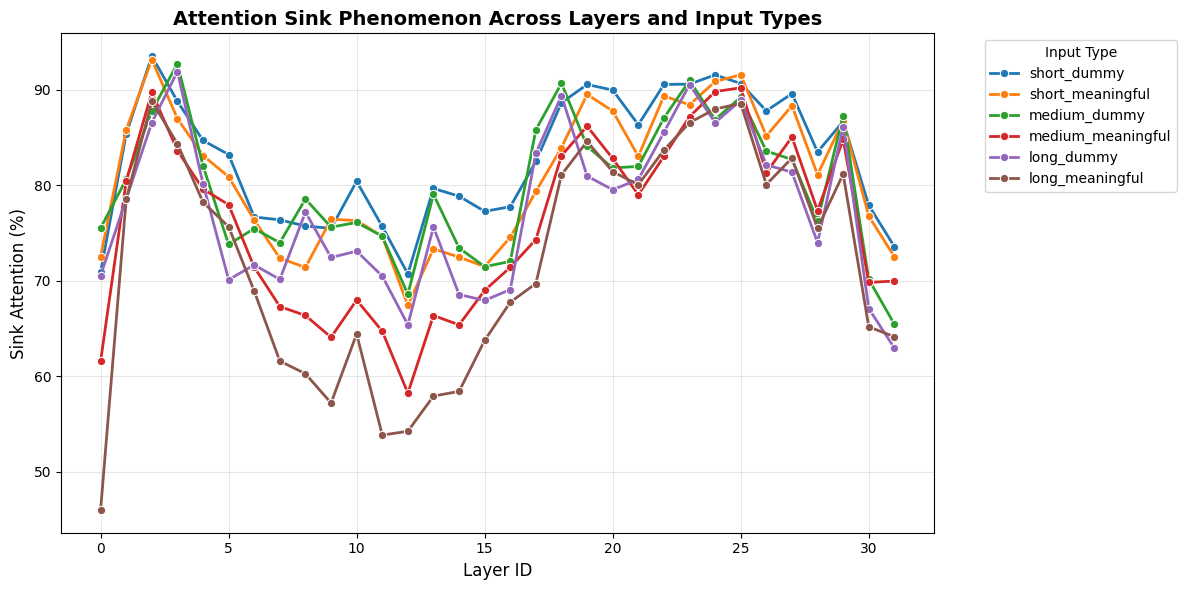

In [107]:
### Cell 7: Experiment - Attention Sink Phenomenon Analysis
print("\n--- Starting Experiment: Attention Sink Phenomenon Analysis ---")
# --- Configurable Section ---
SINK_TOKEN_WINDOW = 4  # TODO: choose number of initial tokens treated as sink tokens
# ---
sink_analysis_results = []
hooks = []  # TODO: register attention hooks across all layers
hooks = register_attention_hooks(model, range(model.config.num_hidden_layers))
for name, text in INPUT_TEXTS.items():
    attention_maps_storage.clear()
    # TODO: tokenize text, run the model with output_attentions=True, and collect attention maps
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256).to(device)
    with torch.no_grad():
        outputs = model(
            **inputs, 
            output_attentions=True
        )
    for layer_idx in range(model.config.num_hidden_layers):
        layer_name = f"layer_{layer_idx}"
        if layer_name in attention_maps_storage:
            # TODO: compute sink attention statistics and append to sink_analysis_results
            attn_map = attention_maps_storage[layer_name][0]
            sink_attention_strength = attn_map[SINK_TOKEN_WINDOW:, :SINK_TOKEN_WINDOW].sum().item()
            total_attention = attn_map[SINK_TOKEN_WINDOW:, :].sum().item()
            sink_percentage = (sink_attention_strength / total_attention) * 100 if total_attention > 0 else 0
            sink_analysis_results.append({"Input Type": name, "Layer ID": layer_idx, "Sink Attention (%)": sink_percentage})
# TODO: remove hooks after analysis
for handle in hooks:
    handle.remove()
# TODO: convert sink_analysis_results into a DataFrame and save to disk
df_sink = pd.DataFrame(sink_analysis_results)
df_sink.to_csv("./results/task_2_attention_sink_analysis.csv", index=False)
# TODO: plot sink attention percentage vs. layer depth for each input type
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sink, x="Layer ID", y="Sink Attention (%)", hue="Input Type", marker="o", linewidth=2)
plt.xlabel("Layer ID", fontsize=12)
plt.ylabel("Sink Attention (%)", fontsize=12)
plt.title("Attention Sink Phenomenon Across Layers and Input Types", fontsize=14, fontweight="bold")
plt.legend(title="Input Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./figures/task_2_attention_sink_analysis.png", dpi=300, bbox_inches="tight")
print("\n--- Attention Sink Analysis Results ---")
# TODO: summarise sink attention statistics and display the plot
print(df_sink.groupby("Input Type")["Sink Attention (%)"].mean().reset_index())
plt.show()

In [96]:
### Cell 8: Bonus Experiment: Modify Standard Attention to StreamingLLM Attention (Task 2 Step 4)
# TODO: import required modules for custom attention (transformers attention utilities, logging, torch.nn, types)
# from transformers.modeling_utils import ALL_ATTENTION_FUNCTIONS
# from transformers.models.llama.modeling_llama import LlamaAttention, rotate_half, repeat_kv
# from transformers.utils import logging
# import torch.nn as nn
# import types


def eager_attention_forward(
    module: nn.Module,
    query: torch.Tensor,
    key: torch.Tensor,
    value: torch.Tensor,
    attention_mask: Optional[torch.Tensor],
    scaling: float,
    dropout: float = 0.0,
    **kwargs,
):
    """
    Implements the standard (eager) attention forward pass.
    """
    key_states = repeat_kv(key, module.num_key_value_groups)
    value_states = repeat_kv(value, module.num_key_value_groups)

    attn_weights = torch.matmul(query, key_states.transpose(2, 3)) * scaling
    if attention_mask is not None:
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    attn_weights = nn.functional.softmax(
        attn_weights, dim=-1, dtype=torch.float32
    ).to(query.dtype)
    attn_weights = nn.functional.dropout(
        attn_weights, p=dropout, training=module.training
    )
    attn_output = torch.matmul(attn_weights, value_states)
    attn_output = attn_output.transpose(1, 2).contiguous()

    return attn_output, attn_weights

def apply_rotary_pos_emb_single(x, cos, sin, position_ids):
    """
    Applies rotary positional embedding to a single tensor.
    """
    # Remove singleton dimensions for broadcasting
    cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed

def apply_rotary_pos_emb_q(q, cos, sin, unsqueeze_dim=1):
    """
    Applies rotary positional embedding to the query tensor.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    return q_embed


# TODO: refer to https://github.com/mit-han-lab/streaming-llm/blob/main/streaming_llm/pos_shift/modify_llama.py
# modify to fit llama3 architecture
def llama_pos_shift_attention_forward(self, hidden_states, position_embeddings, attention_mask, past_key_value, cache_position=None, **kwargs):
    """Modified LLaMA attention forward pass with position shifting for StreamLLM."""
    # TODO: project QKV, update caches, apply rotary embeddings, and compute attention outputs
    ...

def enable_llama_pos_shift_attention(model):
    """Replace standard LlamaAttention.forward methods with the position-shifted variant."""
    # TODO: recursively locate LlamaAttention modules and bind llama_pos_shift_attention_forward
    ...


NameError: name 'nn' is not defined

In [ ]:
### Cell 9: Bonus Experiment: Investigate StreamLLM's Impact on Long-Sequence Memory Usage
# TODO: import tqdm for progress visualisation
# from tqdm.auto import tqdm

print("\n--- Starting Bonus Experiment: Simulating StreamLLM Memory Impact ---")

# --- Configurable Section ---
BONUS_PROMPT = "..."  # TODO: provide long-form prompt
BONUS_GENERATION_LENGTH = ...  # TODO: choose number of tokens to generate
BONUS_SAMPLING_INTERVAL = ...  # TODO: sampling interval for memory measurements
STREAMLLM_CACHE_SIZE = ...  # TODO: number of sink tokens to retain
STREAMLLM_RECENT_SIZE = ...  # TODO: number of most recent tokens to retain
# ---

def run_baseline_experiment(model, tokenizer, prompt, generation_length, sampling_interval, device):
    """Run baseline generation with the standard KV cache while logging memory usage."""
    # TODO: implement generation loop without cache eviction and record GPU memory
    ...

class streamingllm_kv:
    """Implement StreamLLM-style KV cache eviction (retain sink + recent tokens)."""
    def __init__(self, start_size, recent_size, past_key_values):
        # TODO: store configuration for cache trimming
        ...

    def __call__(self, kv_cache):
        """Trim the KV cache according to the StreamLLM policy."""
        # TODO: drop middle tokens while retaining sink and recent tokens
        ...

def run_streamllm_experiment(model, tokenizer, prompt, generation_length, sampling_interval, sink_size, recent_size, device):
    """Run generation with StreamLLM cache eviction and record memory usage."""
    # TODO: enable modified attention, apply streaming cache policy, and log memory
    ...

# =================================================================================
# Main Execution Flow
# =================================================================================

# TODO: prepare chat-formatted prompt and run both baseline and StreamLLM experiments
# messages = [...]
# BONUS_PROMPT = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# memory_baseline, last100words_baseline = run_baseline_experiment(...)
# memory_streamllm, last100words_streamllm = run_streamllm_experiment(...)

# TODO: collate memory usage results, save CSV artifacts, and plot comparisons
# df_mem_compare = pd.concat([...])
# df_mem_compare.to_csv("./results/task2_bonus_memory_comparison.csv", index=False)
# sns.lineplot(...)
# plt.savefig("./figures/task2_bonus_memory_comparison.png", dpi=300)

# TODO: decode and print the final segments from each generation for qualitative comparison
# print(tokenizer.decode(last100words_baseline))
# print(tokenizer.decode(last100words_streamllm))


In [ ]:
### Cell 10: List all generated artifacts for Task 2
print("Task 2 complete. Generated artifacts:")

# TODO: iterate over output directories and list generated files
# if os.path.isdir(FIGURES_DIR):
#     ...
# if os.path.isdir(RESULTS_DIR):
#     ...
